# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [290]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'is_promoted'
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [291]:
import sys
sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')

import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [292]:
dataprep_df_full = pd.read_csv('./HR_Analytics/dataprep_df.csv')
normalized_and_dummy_df = pd.read_csv('./HR_Analytics/normalized_and_dummy_df.csv')

In [293]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [294]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

In [295]:
#Include the new variables
normalized_and_dummy = []
for i in normalized_and_dummy_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)

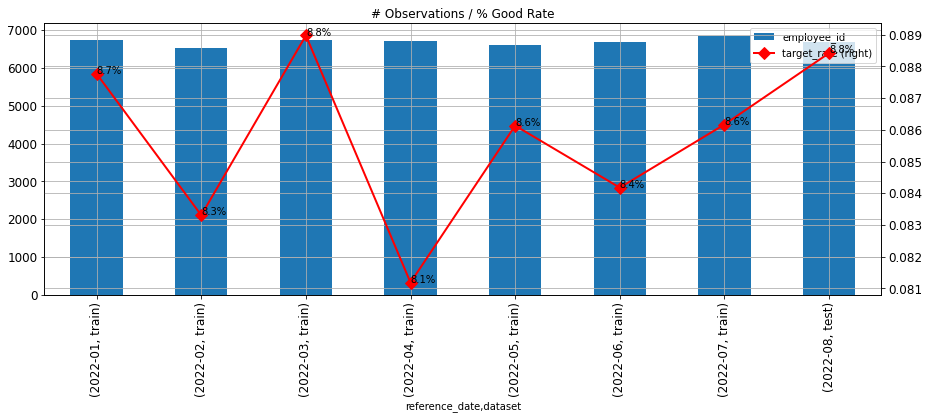

In [296]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [297]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [298]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [299]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: '
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1)
#       + " | "
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [300]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
# h2o.init(nthreads = -1, max_mem_size = '4G')
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,23 hours 22 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,5 months and 7 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_yjvvps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.33 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [301]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 42139
Validation: 4746


In [302]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 6684


## 4.1.2 Using H2O AutoML to performe all algorithms

In [306]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*1*30

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
23:35:14.50: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████

Bad pipe message: %s [b'\xa2\xe3\xd9\xce\xda\x96\xaf\\jD\x97\xf6\xbd\x11@L\x99\xef \xf7 \xec\xdc\x01\n,k\x8c\x1b\xd5\xc7"\xaa\n\xd0\x8e?\x8eV%\xf4\x85j\x12\x16\xb1\xbe\xe9\xdb)\xc8\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04']
Bad pipe message: %s [b'\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xfd\xe7!X\xdb_\xbe\x99\xa9\xbb\x85\xd9\xd3\x02\xb8\xd2\xed\x04*N\xb0O']
Bad pipe message: %s [b"\xd9\r}\xe0\xd6\xfd\x89\x87k\x02\x0e\x0fuu\x83\xbaB\xf6\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\x

████████████████████████████████████████████████| (done) 100%

Execution time: 0:30:02.623234



In [317]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_5_20221215_233514,0.639587,0.914436,0.161379,0.28401,0.21724,0.0471932
GBM_grid_1_AutoML_5_20221215_233514_model_2,0.637166,0.913429,0.167071,0.304246,0.219027,0.0479729
StackedEnsemble_AllModels_2_AutoML_5_20221215_233514,0.631785,0.912349,0.162897,0.299612,0.218492,0.0477389
GBM_5_AutoML_5_20221215_233514,0.631761,0.912744,0.165586,0.288404,0.219472,0.0481678
StackedEnsemble_BestOfFamily_3_AutoML_5_20221215_233514,0.631427,0.911874,0.163019,0.293967,0.218549,0.0477636
XGBoost_grid_1_AutoML_5_20221215_233514_model_13,0.630958,0.91253,0.163901,0.294485,0.219083,0.0479975
GBM_grid_1_AutoML_5_20221215_233514_model_42,0.629798,0.912416,0.166941,0.298601,0.219818,0.04832
GBM_grid_1_AutoML_5_20221215_233514_model_12,0.629629,0.911365,0.166936,0.308476,0.21942,0.0481451
GBM_grid_1_AutoML_5_20221215_233514_model_3,0.629462,0.911932,0.16928,0.296776,0.221082,0.0488774
GBM_grid_1_AutoML_5_20221215_233514_model_17,0.629292,0.911293,0.174999,0.300458,0.223987,0.05017


In [248]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_3_AutoML_3_20221215_21156,0.591185,0.903549,0.165542,0.306481,0.220021,0.0484093
StackedEnsemble_AllModels_2_AutoML_3_20221215_21156,0.59053,0.903681,0.165653,0.313453,0.220154,0.0484678
StackedEnsemble_BestOfFamily_4_AutoML_3_20221215_21156,0.589756,0.901114,0.168121,0.305572,0.220188,0.0484826
StackedEnsemble_BestOfFamily_6_AutoML_3_20221215_21156,0.589674,0.901056,0.168123,0.305724,0.220188,0.0484826
GBM_5_AutoML_3_20221215_21156,0.589104,0.902993,0.169634,0.319362,0.22083,0.0487661
StackedEnsemble_AllModels_3_AutoML_3_20221215_21156,0.585899,0.901755,0.165636,0.29533,0.22017,0.0484749
GBM_grid_1_AutoML_3_20221215_21156_model_181,0.585799,0.902124,0.169476,0.306688,0.221373,0.0490061
StackedEnsemble_BestOfFamily_5_AutoML_3_20221215_21156,0.585735,0.903093,0.167524,0.325376,0.22052,0.0486289
StackedEnsemble_AllModels_4_AutoML_3_20221215_21156,0.585673,0.901705,0.165647,0.294471,0.22017,0.048475
StackedEnsemble_BestOfFamily_2_AutoML_3_20221215_21156,0.585145,0.901258,0.169155,0.309465,0.221869,0.049226


In [319]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_5_20221215_233514

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04621455926161672
RMSE: 0.21497571784184538
LogLoss: 0.15320123082482245
Null degrees of freedom: 10005
Residual degrees of freedom: 10001
Null deviance: 6083.592509871204
Residual deviance: 3065.8630312663477
AIC: 3075.8630312663477
AUC: 0.9428646629308881
AUCPR: 0.7170848911297382
Gini: 0.8857293258617762

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19779907222835988: 


,,0,1,Error,Rate
0,0,8701.0,399.0,0.0438,(399.0/9100.0)
1,1,317.0,589.0,0.3499,(317.0/906.0)
2,Total,9018.0,988.0,0.0716,(716.0/10006.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.197799,0.621964,175.0
1,max f2,0.127426,0.681779,240.0
2,max f0point5,0.333218,0.717426,107.0
3,max accuracy,0.291124,0.942135,121.0
4,max precision,0.999867,1.000000,0.0
5,max recall,0.008554,1.000000,373.0
6,max specificity,0.999867,1.000000,0.0
7,max absolute_mcc,0.266685,0.590261,133.0
8,max min_per_class_accuracy,0.128362,0.855824,239.0
9,max mean_per_class_accuracy,0.120784,0.862385,248.0



Gains/Lift Table: Avg response rate:  9.05 %, avg score:  8.29 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010094,0.997184,11.044150,11.044150,1.000000,0.999530,1.000000,0.999530,0.111479,0.111479,1004.415011,1004.415011,0.111479
1,2,0.020088,0.965617,11.044150,11.044150,1.000000,0.986563,1.000000,0.993079,0.110375,0.221854,1004.415011,1004.415011,0.221854
2,3,0.030082,0.591887,10.602384,10.897384,0.960000,0.858735,0.986711,0.948446,0.105960,0.327815,960.238411,989.738400,0.327375
3,4,0.040076,0.330041,6.847373,9.887406,0.620000,0.410858,0.895262,0.814384,0.068433,0.396247,584.737307,888.740621,0.391632
4,5,0.050070,0.277175,5.853400,9.082215,0.530000,0.296309,0.822355,0.710976,0.058499,0.454746,485.339956,808.221526,0.444966
5,6,0.100040,0.195530,3.975894,6.531605,0.360000,0.226939,0.591409,0.469199,0.198675,0.653422,297.589404,553.160526,0.608477
6,7,0.150010,0.158039,2.253007,5.106356,0.204000,0.176060,0.462358,0.371551,0.112583,0.766004,125.300662,410.635588,0.677323
7,8,0.200080,0.132097,1.565139,4.220167,0.141717,0.144063,0.382118,0.314622,0.078366,0.844371,56.513904,322.016725,0.708437
8,9,0.300020,0.089092,1.016062,3.152844,0.092000,0.110590,0.285476,0.246657,0.101545,0.945916,1.606181,215.284365,0.710202
9,10,0.400060,0.034052,0.375126,2.458241,0.033966,0.065667,0.222583,0.201398,0.037528,0.983444,-62.487402,145.824076,0.641466




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.05093214301572174
RMSE: 0.22568150791706826
LogLoss: 0.1715919749417062
Null degrees of freedom: 4745
Residual degrees of freedom: 4741
Null deviance: 2863.0551419334624
Residual deviance: 1628.7510261466748
AIC: 1638.7510261466748
AUC: 0.906419537960984
AUCPR: 0.6016999034537681
Gini: 0.8128390759219679

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22200278993138903: 


,,0,1,Error,Rate
0,0,4183.0,138.0,0.0319,(138.0/4321.0)
1,1,231.0,194.0,0.5435,(231.0/425.0)
2,Total,4414.0,332.0,0.0777,(369.0/4746.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.222003,0.512550,135.0
1,max f2,0.098146,0.599410,262.0
2,max f0point5,0.615058,0.701493,57.0
3,max accuracy,0.615058,0.939317,57.0
4,max precision,0.999880,1.000000,0.0
5,max recall,0.000804,1.000000,393.0
6,max specificity,0.999880,1.000000,0.0
7,max absolute_mcc,0.615058,0.548900,57.0
8,max min_per_class_accuracy,0.112131,0.802353,244.0
9,max mean_per_class_accuracy,0.072766,0.826042,293.0



Gains/Lift Table: Avg response rate:  8.95 %, avg score:  8.28 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010114,0.996199,11.167059,11.167059,1.000000,0.998979,1.000000,0.998979,0.112941,0.112941,1016.705882,1016.705882,0.112941
1,2,0.020017,0.962732,11.167059,11.167059,1.000000,0.982382,1.000000,0.990768,0.110588,0.223529,1016.705882,1016.705882,0.223529
2,3,0.030131,0.649943,10.236471,10.854694,0.916667,0.875745,0.972028,0.952159,0.103529,0.327059,923.647059,985.469354,0.326133
3,4,0.040034,0.304587,2.851164,8.874873,0.255319,0.410035,0.794737,0.818055,0.028235,0.355294,185.116395,787.487307,0.346268
4,5,0.050147,0.267468,2.326471,7.554187,0.208333,0.283113,0.676471,0.710167,0.023529,0.378824,132.647059,655.418685,0.361004
5,6,0.100084,0.189694,2.874222,5.219131,0.257384,0.219122,0.467368,0.465161,0.143529,0.522353,187.422189,421.913065,0.463802
6,7,0.150021,0.157984,2.261683,4.234699,0.202532,0.171954,0.379213,0.367563,0.112941,0.635294,126.168280,323.469927,0.533003
7,8,0.200169,0.132449,1.736055,3.608723,0.155462,0.144761,0.323158,0.311745,0.087059,0.722353,73.605536,260.872322,0.573545
8,9,0.300042,0.091465,1.531348,2.917237,0.137131,0.112032,0.261236,0.245268,0.152941,0.875294,53.134773,191.723728,0.631832
9,10,0.400126,0.036954,1.034422,2.446286,0.092632,0.067717,0.219063,0.200856,0.103529,0.978824,3.442229,144.628566,0.635616




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.04873479127783656
RMSE: 0.22075957799795812
LogLoss: 0.16708888442956316
Null degrees of freedom: 42138
Residual degrees of freedom: 42134
Null deviance: 24498.505290144414
Residual deviance: 14081.91700195472
AIC: 14091.91700195472
AUC: 0.9043572884820281
AUCPR: 0.5965430600095268
Gini: 0.8087145769640562

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3555977723641836: 


,,0,1,Error,Rate
0,0,38286.0,274.0,0.0071,(274.0/38560.0)
1,1,2264.0,1315.0,0.6326,(2264.0/3579.0)
2,Total,40550.0,1589.0,0.0602,(2538.0/42139.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.355598,0.508901,122.0
1,max f2,0.099137,0.581308,290.0
2,max f0point5,0.549999,0.695495,84.0
3,max accuracy,0.549999,0.942049,84.0
4,max precision,0.999821,1.000000,0.0
5,max recall,0.000864,1.000000,395.0
6,max specificity,0.999821,1.000000,0.0
7,max absolute_mcc,0.549999,0.545547,84.0
8,max min_per_class_accuracy,0.115927,0.801349,274.0
9,max mean_per_class_accuracy,0.082165,0.817434,306.0



Gains/Lift Table: Avg response rate:  8.49 %, avg score:  8.49 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010014,0.995326,11.773959,11.773959,1.000000,0.998977,1.000000,0.998977,0.117910,0.117910,1077.395921,1077.395921,0.117910
1,2,0.020005,0.944231,11.690059,11.732059,0.992874,0.979056,0.996441,0.989028,0.116792,0.234702,1069.005926,1073.205900,0.234625
2,3,0.030020,0.529604,10.044136,11.168973,0.853081,0.791814,0.948617,0.923238,0.100587,0.335289,904.413582,1016.897316,0.333604
3,4,0.040010,0.334243,3.663631,9.294863,0.311164,0.402400,0.789442,0.793183,0.036602,0.371892,266.363101,829.486341,0.362685
4,5,0.050001,0.288610,3.132265,8.063514,0.266033,0.308199,0.684860,0.696278,0.031294,0.403185,213.226468,706.351359,0.385965
5,6,0.100002,0.206433,2.436377,5.249945,0.206929,0.238855,0.445895,0.467567,0.121822,0.525007,143.637694,424.994527,0.464452
6,7,0.150004,0.168145,2.168152,4.222681,0.184148,0.185986,0.358646,0.373706,0.108410,0.633417,116.815196,322.268083,0.528282
7,8,0.200005,0.139761,1.849635,3.629419,0.157095,0.153477,0.308258,0.318649,0.092484,0.725901,84.963479,262.941932,0.574708
8,9,0.300007,0.093301,1.489207,2.916015,0.126483,0.116023,0.247667,0.251107,0.148924,0.874825,48.920746,191.601537,0.628171
9,10,0.400009,0.037347,0.894083,2.410532,0.075937,0.067748,0.204734,0.205267,0.089410,0.964236,-10.591672,141.053235,0.616596




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.939204,0.003540,0.935850,0.943953,0.940852,0.939798,0.935565
1,auc,0.904370,0.003761,0.903590,0.908077,0.907758,0.903536,0.898888
2,err,0.060796,0.003540,0.064150,0.056047,0.059148,0.060202,0.064435
3,err_count,512.400000,30.369392,542.000000,469.000000,504.000000,506.000000,541.000000
4,f0point5,0.656053,0.037326,0.598291,0.682711,0.694731,0.653003,0.651530
5,f1,0.513588,0.019998,0.495345,0.542439,0.516315,0.519924,0.493920
6,f2,0.422607,0.019968,0.422625,0.449984,0.410812,0.431904,0.397710
7,lift_top_group,11.788544,0.450383,12.227207,12.162790,11.452957,11.905099,11.194667
8,logloss,0.167073,0.006419,0.164904,0.160154,0.167362,0.165412,0.177533
9,max_per_class_error,0.621864,0.021072,0.615051,0.595930,0.638441,0.611898,0.648000



See the whole table with table.as_data_frame()



stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


Text(0.5, 1.0, 'ROC Curve for Model (Test dataset)')

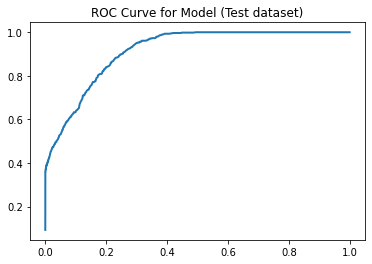

In [320]:
#Save all models in H20 format
h2o.save_model(model=best_AutoML, path='%s/models/candidates/' % OutputPath, force=True)
#calculate o KS in test dataset
h2o_predict = best_AutoML.predict(test_hdf)
data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
data['target0'] = 1 - data[VarTarget]
data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
grouped = data.groupby('bucket', as_index=False)
kstable = pd.DataFrame()
kstable['min_prob'] = grouped.min()['p1']
kstable['max_prob'] = grouped.max()['p1']
kstable['events'] = grouped.sum()[VarTarget]
kstable['nonevents'] = grouped.sum()['target0']    
kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
ks = kstable['KS'].max()

#Ascertain the performance of all models on the test base
performance = best_AutoML.model_performance(test_hdf)

#Salve metrics
f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, best_AutoML.model_id), 'w')
f.write(
    str(best_AutoML.model_id) + ";"
    + str(performance.accuracy()[0][0]) + ";"
    + str(performance.auc()) + ';'
    + str(performance.aucpr()) + ';'
    + str(performance.logloss()) + ';'
    + str(ks) + ';'
    + str(performance.F1()[0][0]))
f.write('\n')
f.close()

#graph with the ROC curve of all models
fpr = performance.fprs
tpr = performance.tprs
plt.plot(fpr, tpr, lw=2, label=best_AutoML.model_id.split("_")[0]+"_"+best_AutoML.model_id.split("_")[1]+"_"+best_AutoML.model_id.split("_")[2])
plt.title("ROC Curve for Model (Test dataset)")

In [321]:
df_plot = pd.DataFrame({'Model_id': 'H2O AutoML v2',
                        'AUC': int(performance.auc()*100)/100,
                        'F1': int(performance.F1()[0][0]*100)/100,
                        'Accuracy': int(performance.accuracy()[0][0]*100)/100
                        }, index=[0])

In [323]:
h2o_predict_df = data[[VarTarget, 'predict']].rename(columns={VarTarget:'test_actual', 'predict':'test_predicted'})
h2o_predict_df

,test_actual,test_predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
6679,0,0
6680,0,0
6681,0,0
6682,0,0


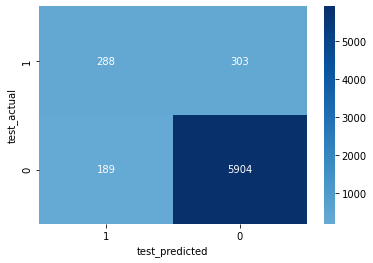

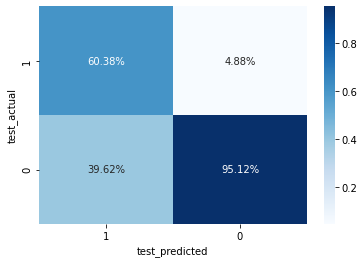

In [324]:
h2o_predict_df = data[[VarTarget, 'predict']].rename(columns={VarTarget:'test_actual', 'predict':'test_predicted'})

h2o_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False)
df_matrix = h2o_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False).loc[:,(1,0)]
sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 4.1.3 H2O Submision dataset

In [325]:
submission_df = pd.read_csv('./HR_Analytics/submission_df.csv')
submission_df

,employee_id,department,region,education,gender,recruitment_channel,kpis_met_80,no_of_trainings,previous_year_rating,age,length_of_service,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,1,3.339146,24,1,77
1,74430,HR,region_4,Bachelor's,f,other,0,1,3.000000,31,5,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,0,1,1.000000,31,4,47
3,38562,Procurement,region_2,Bachelor's,f,other,0,3,2.000000,31,9,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,0,1,4.000000,30,7,61
...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,Legal,region_2,Below Secondary,m,sourcing,0,1,3.000000,24,1,61
23486,25600,Technology,region_25,Bachelor's,m,sourcing,0,1,3.000000,31,7,74
23487,45409,HR,region_16,Bachelor's,f,sourcing,0,1,4.000000,26,4,50
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,0,3,3.339146,27,1,70


In [326]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/fiep-gpu/code/FIEP-Machine-Learning-e-Computacao-em-Nuvem/aula_03_hr_analytics_keras/output_model/models/best/StackedEnsemble_BestOfFamily_4_AutoML_5_20221215_233514.zip'

In [327]:
#Importar MOJO
submission_df_tmp = h2o.mojo_predict_pandas(submission_df, path_model_mojo)    
predict_df = submission_df.merge(submission_df_tmp, left_index=True, right_index=True)
    
predict_df.rename(columns={'predict':'is_promoted'}, inplace=True)
predict_df = predict_df.reset_index(drop=True)

Detected 2 unused columns in the input data set: {,employee_id}


In [328]:
predict_df.loc[:, (VarId, VarTarget)].to_csv('./HR_Analytics/results/H2O_AutoML_submission.csv', index=False)
predict_df[VarTarget].value_counts()

0    21844
1     1646
Name: is_promoted, dtype: int64

## 4.2 Keras

In [356]:
x_train = normalized_and_dummy_df.query('dataset == "train"').loc[:, (normalized_and_dummy)].to_numpy()
y_train = normalized_and_dummy_df.query('dataset == "train"').loc[:, (VarTarget)].to_numpy()
print("shape of x train: {}\nshape of y train: {}".format(x_train.shape, y_train.shape))

shape of x train: (46885, 53)
shape of y train: (46885,)


In [357]:
x_test = normalized_and_dummy_df.query('dataset == "test"').loc[:, (normalized_and_dummy)].to_numpy()
y_test = normalized_and_dummy_df.query('dataset == "test"').loc[:, (VarTarget)].to_numpy()
print("shape of x test: {}\nshape of y test: {}".format(x_test.shape,y_test.shape))

shape of x test: (6684, 53)
shape of y test: (6684,)


In [331]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [332]:
import tensorflow
print('GPU name: ', tensorflow.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [333]:
model_keras = Sequential()
model_keras.add(Dense(256, activation = 'relu', input_dim = 53))
model_keras.add(Dense(256, activation = 'relu'))
model_keras.add(Dense(1))
model_keras.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])
model_keras.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               13824     
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dense_24 (Dense)            (None, 1)                 257       
                                                                 
Total params: 79,873
Trainable params: 79,873
Non-trainable params: 0
_________________________________________________________________


In [334]:
%%time
model_keras.fit(x=x_train, y=y_train, batch_size=42, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1117/1117 [==============================] - 9s 8ms/step - loss: 0.0912 - accuracy: 0.9146 - val_loss: 0.0896 - val_accuracy: 0.9116
Epoch 2/10
1117/1117 [==============================] - 8s 7ms/step - loss: 0.0862 - accuracy: 0.9146 - val_loss: 0.0891 - val_accuracy: 0.9116
Epoch 3/10
1117/1117 [==============================] - 8s 7ms/step - loss: 0.0858 - accuracy: 0.9146 - val_loss: 0.0886 - val_accuracy: 0.9116
Epoch 4/10
1117/1117 [==============================] - 8s 7ms/step - loss: 0.0837 - accuracy: 0.9164 - val_loss: 0.0815 - val_accuracy: 0.9195
Epoch 5/10
1117/1117 [==============================] - 8s 7ms/step - loss: 0.0752 - accuracy: 0.9260 - val_loss: 0.0742 - val_accuracy: 0.9262
Epoch 6/10
1117/1117 [==============================] - 9s 8ms/step - loss: 0.0707 - accuracy: 0.9328 - val_loss: 0.0693 - val_accuracy: 0.9337
Epoch 7/10
1117/1117 [==============================] - 7s 6ms/step - loss: 0.0659 - accuracy: 0.9379 - val_loss: 0.0653 - val_accuracy:

In [335]:
#predict using model.predict
predictions = model_keras.predict(x_test)

209/209 [==============================] - 0s 1ms/step


In [344]:
#get the classes from the prediction
y_predicted = predictions
y_predicted[y_predicted <= 0.5] = 0
y_predicted[y_predicted > 0.5] = 1

In [345]:
keras_predict_df.value_counts()

test_actual  test_predicted
0            0                 6089
1            0                  397
             1                  194
0            1                    4
dtype: int64

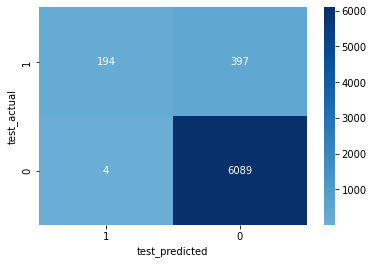

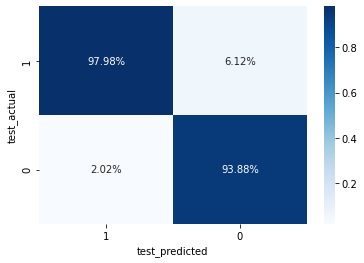

In [346]:
keras_predict_df = pd.DataFrame(y_test, columns=['test_actual'])
keras_predict_df['test_predicted'] = y_predicted
keras_predict_df['test_predicted'] = keras_predict_df['test_predicted'].astype(int)
keras_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False)
df_matrix = keras_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False).loc[:,(1,0)]
sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

In [347]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
df_plot = df_plot.append(pd.DataFrame({'Model_id': 'Keras_GPU',
                            'AUC': int(roc_auc_score(y_test, y_predicted)*100)/100,
                            'F1': int(f1_score(y_test, y_predicted)*100)/100,
                            'Accuracy': int(accuracy_score(y_test, y_predicted)*100)/100
                            }, index=[0]))

## 4.2.1 Keras Submision dataset

In [348]:
submission_normalized_and_dummy_df = pd.read_csv('./HR_Analytics/submission_normalized_and_dummy_df.csv')
x_submission = submission_normalized_and_dummy_df.loc[:, (normalized_and_dummy)].to_numpy()

In [349]:
y_submission = model_keras.predict(x_submission)
y_submission[y_submission <= 0.5] = 0
y_submission[y_submission > 0.5] = 1

735/735 [==============================] - 1s 1ms/step


In [350]:
submission_normalized_and_dummy_df[VarTarget] = y_submission
submission_normalized_and_dummy_df[VarTarget] = submission_normalized_and_dummy_df[VarTarget].astype(int)
submission_normalized_and_dummy_df.loc[:, (VarId, VarTarget)].loc[:, (VarId, VarTarget)].to_csv('./HR_Analytics/results/Keras_submission.csv', index=False)
submission_normalized_and_dummy_df[VarTarget].value_counts()

0    22860
1      630
Name: is_promoted, dtype: int64

## 4.3 XGBosst

In [351]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [352]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [353]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [354]:
def objective(space):
    clf=xgb.XGBClassifier(use_label_encoder=False,
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( x_train, y_train), (x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [355]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9115798922800719                                     
SCORE:                                                                            
0.9115798922800719                                                                
SCORE:                                                                            
0.9115798922800719                                                                
SCORE:                                                                            
0.9115798922800719                                                                
SCORE:                                                                            
0.9115798922800719                                                                
SCORE:                                                                            
0.9115798922800719                                                                
SCORE:                                                    

In [360]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5624216787963368, 'gamma': 6.90723564411184, 'max_depth': 17.0, 'min_child_weight': 8.0, 'reg_alpha': 105.0, 'reg_lambda': 0.8681229951938159}


In [361]:
clf=xgb.XGBClassifier(use_label_encoder=False,
                      colsample_bytree=best_hyperparams['colsample_bytree'],
                      gamma=best_hyperparams['gamma'],
                      max_depth= int(best_hyperparams['max_depth']),
                      min_child_weight=int(best_hyperparams['min_child_weight']),
                      reg_alpha= int(best_hyperparams['min_child_weight']),
                      reg_lambda= best_hyperparams['reg_lambda'])
evaluation = [( x_train, y_train), (x_test, y_test)]

clf.fit(x_train, y_train,
        eval_set=evaluation, eval_metric="aucpr",
        early_stopping_rounds=10,verbose=False)


pred = clf.predict(x_test)

In [362]:
pred_gxboost = clf.predict(x_test)
accuracy = accuracy_score(y_test, pred_gxboost>0.5)
accuracy

0.9412028725314183

In [365]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
df_plot = df_plot.append(pd.DataFrame({'Model_id': 'XGBoost',
                            'AUC': int(roc_auc_score(y_test, pred_gxboost)*100)/100,
                            'F1': int(f1_score(y_test, pred_gxboost)*100)/100,
                            'Accuracy': int(accuracy_score(y_test, pred_gxboost)*100)/100
                            }, index=[0]))

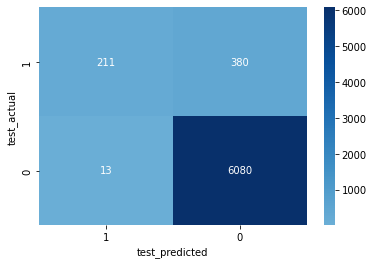

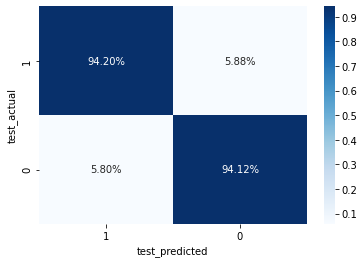

In [366]:
xgboost_predict_df = pd.DataFrame(y_test, columns=['test_actual'])
xgboost_predict_df['test_predicted'] = pred_gxboost
xgboost_predict_df['test_predicted'] = xgboost_predict_df['test_predicted'].astype(int)
xgboost_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False)
df_matrix = xgboost_predict_df.reset_index().groupby(['test_actual', 'test_predicted']).count()[['index']].reset_index().pivot(index='test_actual', columns='test_predicted', values='index').sort_values(by=['test_actual'], ascending=False).loc[:,(1,0)]
sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 4.3.1 XGBoost Submision dataset

In [370]:
submission_normalized_and_dummy_df = pd.read_csv('./HR_Analytics/submission_normalized_and_dummy_df.csv')
x_submission = submission_normalized_and_dummy_df.loc[:, (normalized_and_dummy)].to_numpy()

In [371]:
y_submission = clf.predict(x_submission)
y_submission[y_submission <= 0.5] = 0
y_submission[y_submission > 0.5] = 1

In [372]:
submission_normalized_and_dummy_df[VarTarget] = y_submission
submission_normalized_and_dummy_df[VarTarget] = submission_normalized_and_dummy_df[VarTarget].astype(int)
submission_normalized_and_dummy_df.loc[:, (VarId, VarTarget)].loc[:, (VarId, VarTarget)].to_csv('./HR_Analytics/results/XGBoost_submission.csv', index=False)
submission_normalized_and_dummy_df[VarTarget].value_counts()

0    22835
1      655
Name: is_promoted, dtype: int64

# 5. Compare All the Models

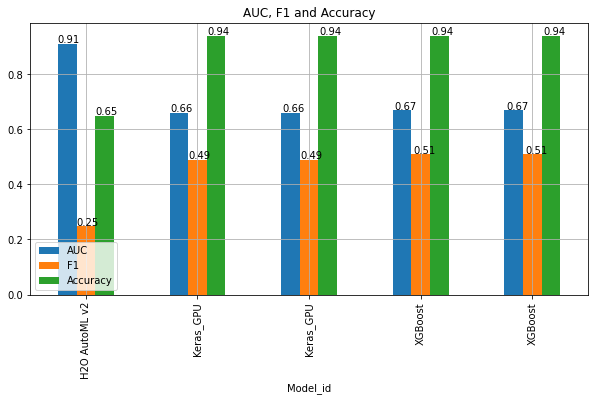

In [373]:
ax = df_plot.plot(kind='bar', x="Model_id", title="AUC, F1 and Accuracy", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})